# Task

Exploratory Data Analysis of Polish Twitter [dataset](http://2019.poleval.pl/index.php/tasks/task6)

# Init

## Importing modules

In [3]:
import re
import os
import string
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy

plt.style.use('seaborn')
# sns.set_palette('hls', 8)
# sns.set_palette('pastel')


In [4]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer

## Constants

In [5]:
DATA_DIR = 'data/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train/')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test/')

MAX_TWEET_LENGTH = 280

In [6]:
class Labels(Enum):
    NON_HARMFUL = 0
    HARMFUL = 1

## Helper functions 

In [7]:
def display_full_df(df) -> None:
    """Displays a df with no fixed width and a specified number of rows."""
    
    pd.set_option('display.max_columns', None)  # or 1000
    pd.set_option('display.max_rows', None)  # or 1000
    pd.set_option('display.max_colwidth', None)  # or 199
    print(df)


# Analysis

## Loading data

In [16]:
os.listdir(TRAIN_DATA_DIR)

['training_set_clean_only_tags.txt', 'training_set_clean_only_text.txt']

In [17]:
TRAIN_DATA = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[1])
TRAIN_LABELS = os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[0])

Read .txt data with `\n` as delimeter

In [27]:
def read_txt(path):
    with open(path, 'r') as f:
      return f.readlines()  

In [35]:
train_data = read_txt(TRAIN_DATA)
train_labels = read_txt(TRAIN_LABELS)

train_data = list(map(lambda x: x.replace('\n', ''), train_data))
train_labels = list(map(lambda x: x.replace('\n', ''), train_labels))

print('Dataset size', len(train_data), len(train_labels))


Dataset size 10041 10041


### Transform to dataframes

In [43]:
data_df = pd.DataFrame(train_data, columns=['text'])
labels_df = pd.DataFrame(train_labels, columns=['label'])

data_df.shape, labels_df.shape

((10041, 1), (10041, 1))

In [44]:
data_df.head()

,text
0,Dla mnie faworytem do tytułu będzie Cracovia. ...
1,@anonymized_account @anonymized_account Brawo ...
2,"@anonymized_account @anonymized_account Super,..."
3,@anonymized_account @anonymized_account Musi. ...
4,"Odrzut natychmiastowy, kwaśna mina, mam problem"


In [45]:
labels_df.head()

,label
0,0
1,0
2,0
3,0
4,0


Concatenating dataframes

In [62]:
df = pd.concat([data_df, labels_df], axis=1)
df.head()

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


## EDA

### Null values

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10041 entries, 0 to 10040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10041 non-null  object
 1   label   10041 non-null  object
dtypes: object(2)
memory usage: 157.0+ KB


In [66]:
df['label'] = df['label'].astype('int')


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10041 entries, 0 to 10040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10041 non-null  object
 1   label   10041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.0+ KB


In [68]:
df.isnull().sum()

text     0
label    0
dtype: int64

No null values

### Labels

In [69]:
df['label'].unique()

array([0, 1])

No incorrect labels

### Duplicate values

In [70]:
df = df.filter(items=list(df['text'].str.lower().drop_duplicates().index), axis=0).reset_index(drop=True)
df.shape

(10026, 2)

### Distribution of labels

In [71]:
df['label'].value_counts()

0    9177
1     849
Name: label, dtype: int64

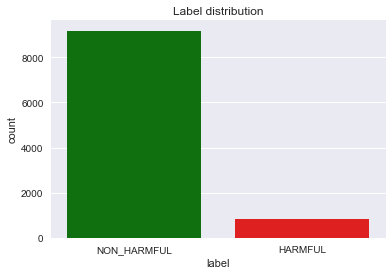

In [72]:
# Customization
hue_colors = {Labels.NON_HARMFUL.value: 'green',
              Labels.HARMFUL.value: 'red'}

plt.xticks(range(2), ['Positive [0]', 'Negative [1]'])
plt.title('Label distribution')

sns.countplot(x='label', data=df, palette=hue_colors)

plt.xticks(range(2), [Labels.NON_HARMFUL.name, Labels.HARMFUL.name])
plt.show()

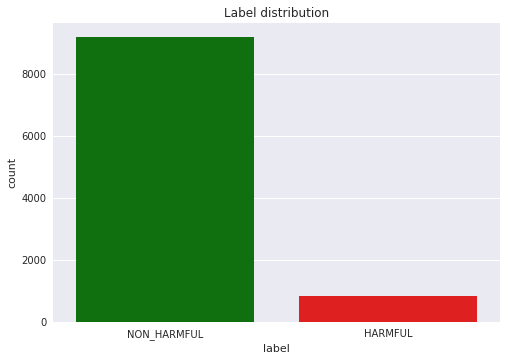

In [ ]:
# Customization
hue_colors = {Labels.NON_HARMFUL.value: 'green',
              Labels.HARMFUL.value: 'red'}

plt.xticks(range(2), ['Positive [0]', 'Negative [1]'])
plt.title('Label distribution')

sns.countplot(x='label', data=df, palette=hue_colors)

plt.xticks(range(2), [Labels.NON_HARMFUL.name, Labels.HARMFUL.name])
plt.show()

Unfortunately the labels are not equally distributed. This may be a significant problem and has to be considered in evaluation metrics.

### Length of tweets

In [74]:
tweet_lengths = df.copy()
tweet_lengths['length'] = tweet_lengths['text'].str.len()
tweet_lengths.head()

,text,label,length
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,78
1,@anonymized_account @anonymized_account Brawo ...,0,82
2,"@anonymized_account @anonymized_account Super,...",0,125
3,@anonymized_account @anonymized_account Musi. ...,0,67
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,47


Average and Median tweet length

In [75]:
print(f'Average tweet length: {int(np.mean(tweet_lengths["length"]))}')
print(f'Median tweet length: {int(np.median(tweet_lengths["length"]))}')

Average tweet length: 93
Median tweet length: 91


In [81]:
print(f'Average tweet length: {int(np.mean(tweet_lengths["length"]))}')
print(f'Median tweet length: {int(np.median(tweet_lengths["length"]))}')

Average tweet length: 93
Median tweet length: 91


Average and Median tweet length compared to the max tweet length

In [82]:
print(f'Average tweet length / tweet max length ratio: {round(np.mean(tweet_lengths["length"]) / MAX_TWEET_LENGTH, 3)}')
print(f'Median tweet length / tweet max length ratio: {round(np.median(tweet_lengths["length"]) / MAX_TWEET_LENGTH, 3)}')

Average tweet length / tweet max length ratio: 0.335
Median tweet length / tweet max length ratio: 0.325


In most cases, people only use 30% of the max tweet length

### Does the tweet length correlate with the tweet's sentiment?

Tweet length distribution

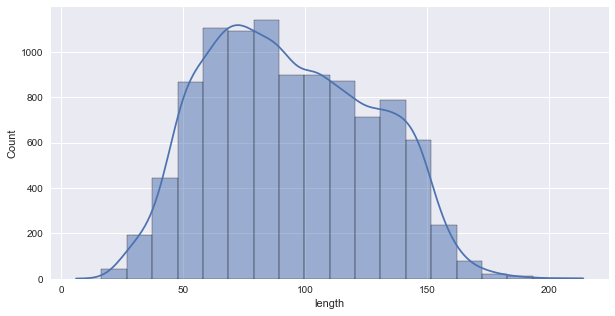

In [83]:
plt.figure(figsize=(10,5))
sns.histplot(x='length', data=tweet_lengths, kde=True, bins=20)
plt.show()

It seems like the tweet length is having a normal (right skewed) distribution, and it is. How does the distribution look like for each class?

### Tweet length distribution by class

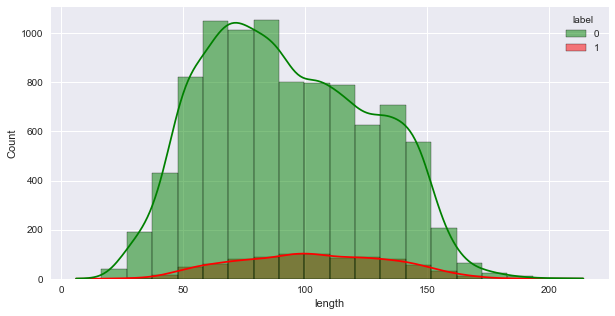

In [84]:
plt.figure(figsize=(10,5))
sns.histplot(x='length', data=tweet_lengths, kde=True, hue='label', bins=20, palette=hue_colors)
plt.show()


The number of classes is not well distributed, let's examine the distribution for each class separately

- Positive sentiment

[]

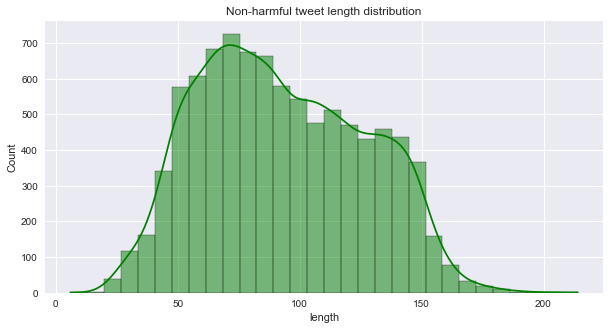

In [85]:
plt.figure(figsize=(10,5))
g = sns.histplot(x='length', data=tweet_lengths[tweet_lengths['label'] == Labels.NON_HARMFUL.value], kde=True, color='green', bins=30)
g.set_title('Non-harmful tweet length distribution')
plt.plot()

Right skewed distribution (positive skewness)

In [86]:
tweet_lengths[tweet_lengths['label'] == Labels.NON_HARMFUL.value]['length'].mode()

0    65
Name: length, dtype: int64

The most frequent non harmful tweet length (mode - dominanta) is somewhere about 65-80

- Negative sentiment

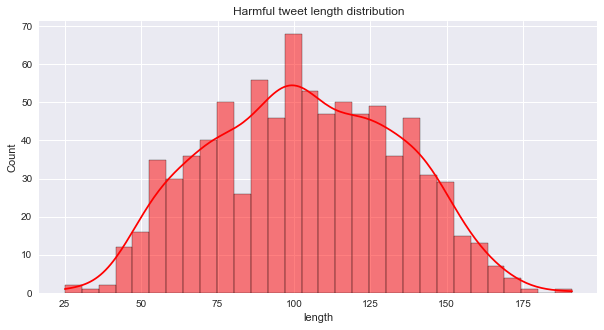

In [87]:
plt.figure(figsize=(10,5))
g = sns.histplot(x='length', data=tweet_lengths[tweet_lengths['label'] == Labels.HARMFUL.value], kde=True, color='red', bins=30)
g.set_title('Harmful tweet length distribution')
plt.show()

Normal distribution

In [88]:
tweet_lengths[tweet_lengths['label'] == Labels.HARMFUL.value]['length'].mode()

0     97
1    103
Name: length, dtype: int64

The most frequent, harmful tweet length (mode - dominanta) is somewhere about 95 - 105

It looks like that the tweet length may be correlated with the sentiment, as the tweets with negative sentiment are usually longer.

In [89]:
label_median_lengths = tweet_lengths[['label', 'length']].groupby('label').median()
label_median_lengths

,length
label,
0,89.0
1,103.0


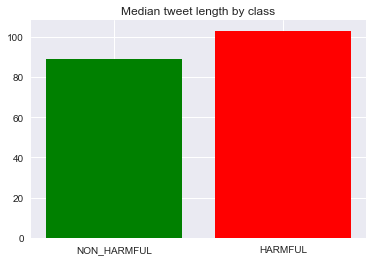

In [90]:
plt.bar(label_median_lengths.index, label_median_lengths.length, color=['g', 'r'])
plt.xticks(range(2), [Labels.NON_HARMFUL.value, Labels.HARMFUL.value])

plt.xticks(range(2), [Labels.NON_HARMFUL.name, Labels.HARMFUL.name])
plt.title('Median tweet length by class')
plt.show()

In most cases a negative tweet is longer.
Adding a `length` column to the training dataset may be a good idea

## Word Counts (Bag-of-Words)

Counting each word occurrences in every tweet 

In [91]:
count_vectorizer = CountVectorizer()

In [92]:
cv_transformed = count_vectorizer.fit_transform(df['text']).toarray()
count_vectorizer.get_feature_names()[1000:1020]

/Users/Kuba/miniforge3/envs/ML/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['biedak',
 'biedaku',
 'biedna',
 'biedne',
 'biednego',
 'biedni',
 'biedniejsze',
 'biedniejszych',
 'biedny',
 'biedronce',
 'biedronka',
 'biedronki',
 'biedroń',
 'biedy',
 'biedę',
 'bieg',
 'biega',
 'biegali',
 'biegam',
 'biegania']

In [93]:
df_cv = pd.DataFrame(cv_transformed, columns=count_vectorizer.get_feature_names())
df_cv.head()

,00,01,02s91ipder,03,04,06,0888888888,0jdgav1mow,0q4pyaqhlz,0sxlbtcpgh,...,żądza,żądło,żłobu,лайка,איזה,הנשיא,מצוין,פולני,רעיון,של
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- ### Number of words per tweet

In [94]:
num_words_per_tweet = df_cv.sum(axis=1)
num_words_per_tweet

0        12
1        11
2        13
3         7
4         6
         ..
10021     5
10022    16
10023     8
10024    14
10025     6
Length: 10026, dtype: int64

- Average and Median number of words per tweet 

In [95]:
print(f'Average number of words in a tweet: {int(np.mean(num_words_per_tweet))}')
print(f'Median number of words in a tweet: {int(np.median(num_words_per_tweet))}')

Average number of words in a tweet: 11
Median number of words in a tweet: 11


In [96]:
print(f'Average number of words in a tweet: {int(np.mean(num_words_per_tweet))}')
print(f'Median number of words in a tweet: {int(np.median(num_words_per_tweet))}')

Average number of words in a tweet: 11
Median number of words in a tweet: 11


- Distribution of the number of words per tweet

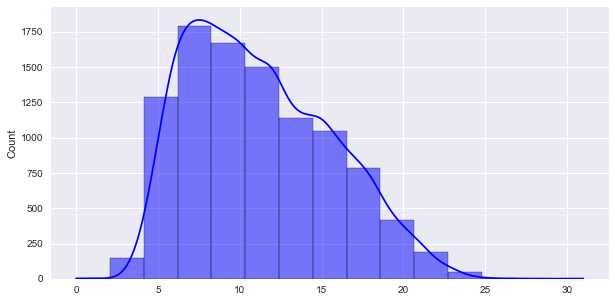

In [97]:
plt.figure(figsize=(10, 5))
sns.histplot(num_words_per_tweet, bins=15, kde=True, color='blue')

plt.show()

Right skewed distribution

- Distribution of the number of words for each class

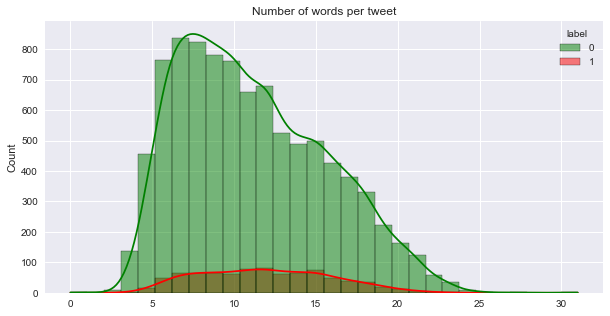

In [98]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=num_words_per_tweet, bins=30, kde=True, hue=df['label'], palette=hue_colors)
g.set_title('Number of words per tweet')
plt.show()

As previously, the number of classes is not well distributed, let's examine the distribution for each class separately

- #### Non-harmful

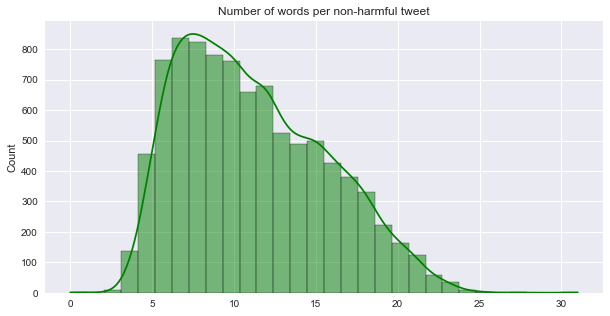

In [99]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=num_words_per_tweet[df['label'] == Labels.NON_HARMFUL.value], bins=30, kde=True, color='g')
g.set_title('Number of words per non-harmful tweet')
plt.show()

Right skewed distribution

- Calculating the mode

In [100]:
num_words_per_tweet[df['label'] == Labels.NON_HARMFUL.value].mode()

0    7
dtype: int64

Non harmful tweets have in most cases a length of 6-7 words

- #### Harmful

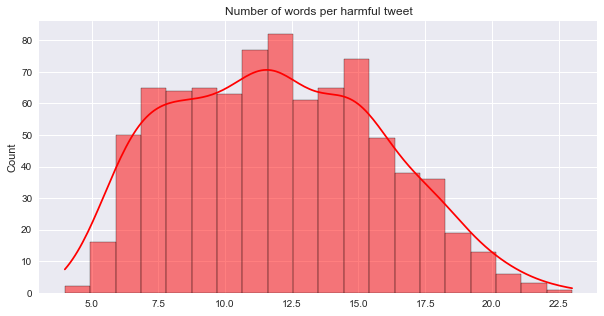

In [101]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=num_words_per_tweet[df['label'] == Labels.HARMFUL.value], bins=20, kde=True, color='r')
g.set_title('Number of words per harmful tweet')
plt.show()

Seems to be a normal distribution

- Mode

In [102]:
num_words_per_tweet[df['label'] == Labels.HARMFUL.value].mode()

0    12
dtype: int64

Harmful tweets have in most cases a length of 11-12 words

The analysis above shows us, that adding a column with the number of words in a tweet could be a good idea, as the number of words differs for each class

    Of course, in the calculations above we did include the all numbers and symbols, however we are exploring the raw dataset for now. Further evaluation should be performed after removing numbers, emoji's and other symbols incorrecly recognized as words 

- #### Average and Median word length

In [103]:
word_lengths = {word: len(word) for word in df_cv.columns}

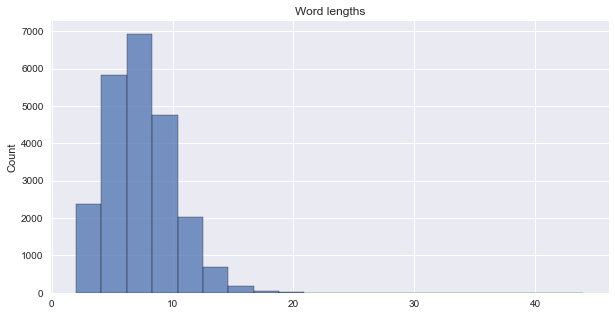

In [104]:
plt.figure(figsize=(10, 5))
g = sns.histplot(x=word_lengths.values(), bins=20)
g.set_title('Word lengths')
plt.show()

- ## Most frequent words

In [105]:
word_occurrences = df_cv.sum(axis=0)
word_occurrences

00            25
01             5
02s91ipder     1
03             1
04             1
              ..
הנשיא          2
מצוין          2
פולני          2
רעיון          2
של             2
Length: 22872, dtype: int64

In [106]:
word_occurrences.describe()

count    22872.000000
mean         4.941151
std         99.997441
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      13759.000000
dtype: float64

In [107]:
sorted_word_occurrences = word_occurrences.sort_values(ascending=False)
sorted_word_occurrences

anonymized_account    13759
nie                    3129
to                     2991
na                     2091
się                    1802
                      ...  
piesku                    1
pietruszki                1
pietruszkę                1
pietrzak                  1
przeniosło                1
Length: 22872, dtype: int64

In [108]:
num_words = len(word_occurrences)
num_words

22872

In [109]:
np.sum(word_occurrences > 1)

9419

In [110]:
np.sum(word_occurrences > 1) / num_words

0.41181357117873385

60% of all words occur only once, lets examine the distribution

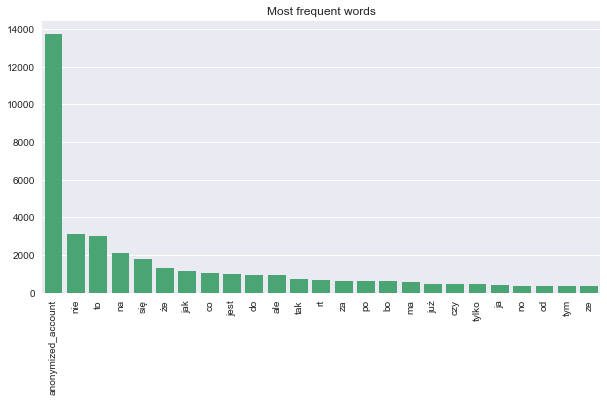

In [111]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences[:25].index, y=sorted_word_occurrences[:25].values, color='mediumseagreen')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

Exponential distribution (Long tail)

As we can see, most of these are stop words, let's remove them and get the most frequent ones.

### Temporarily removing Polish stopwords, to get the most frequent words of the dataset

- #### Removing new line chars

In [112]:
def filter_newline(text):
    return text.replace('\\n', ' ').replace('\\r', ' ')

In [113]:
filtered_df = df['text'].str.lower().apply(filter_newline)
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Removing URLs

In [114]:
url_pattern = r'((www.[^s]+)|(https?://[^s]+))'

In [115]:
def filter_url(text, url_pattern):
    return re.sub(url_pattern, ' ', text)

In [116]:
filtered_df = filtered_df.apply(lambda x: filter_url(x, url_pattern))
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Removing numbers

In [117]:
def filter_numbers(text):
    number_pattern = r'[0-9]+'
    return re.sub(number_pattern, '', text)

In [118]:
filtered_df = filtered_df.apply(filter_numbers)
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Filter non ASCII characters

In [119]:
def filter_ascii(text):
    return re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', '', text) 

In [120]:
filtered_df = filtered_df.apply(filter_ascii)
filtered_df.head()

0    dla mnie faworytem do tytułu będzie cracovia. ...
1    @anonymized_account @anonymized_account brawo ...
2    @anonymized_account @anonymized_account super,...
3    @anonymized_account @anonymized_account musi. ...
4      odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object

- #### Removing punctuations

In [121]:
def filter_punctuations(text, punctuations):
    translator = str.maketrans('', '', punctuations)
    return text.translate(translator)

In [122]:
filtered_df = filtered_df.apply(lambda x: filter_punctuations(x, string.punctuation))
filtered_df

0        dla mnie faworytem do tytułu będzie cracovia z...
1        anonymizedaccount anonymizedaccount brawo ty d...
2        anonymizedaccount anonymizedaccount super pols...
3        anonymizedaccount anonymizedaccount musi innej...
4            odrzut natychmiastowy kwaśna mina mam problem
                               ...                        
10021         anonymizedaccount ty zagrasz nie wiedziałem 
10022    anonymizedaccount anonymizedaccount a var nie ...
10023    anonymizedaccount anonymizedaccount szanowany ...
10024    anonymizedaccount anonymizedaccount anonymized...
10025    anonymizedaccount a wróżbita maciej mówi że zr...
Name: text, Length: 10026, dtype: object

- #### Lemmatization

In [123]:
lemma_model = spacy.load('pl_core_news_sm')

OSError: [E050] Can't find model 'pl_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [99]:
def lemmatize_sentence(lemma_model, text):
    doc = lemma_model(text)
    return ' '.join([token.lemma_ for token in doc])

In [100]:
df_lemmatized = filtered_df.apply(lambda x: lemmatize_sentence(lemma_model, x))
df_lemmatized.head()

0    dla ja faworyt do tytuł być cracovia zobaczyć ...
1    anonymizedaccount anonymizedaccount brawo ty d...
2    anonymizedaccount anonymizedaccount super pols...
3    anonymizedaccount anonymizedaccount musić inny...
4       odrzut natychmiastowy kwaśna mina mieć problem
Name: text, dtype: object

- #### Tokenizing words

In [102]:
tweet_tokenizer = TweetTokenizer()

In [103]:
tokenized_df = df_lemmatized.apply(tweet_tokenizer.tokenize)
tokenized_df

0        [dla, ja, faworyt, do, tytuł, być, cracovia, z...
1        [anonymizedaccount, anonymizedaccount, brawo, ...
2        [anonymizedaccount, anonymizedaccount, super, ...
3        [anonymizedaccount, anonymizedaccount, musić, ...
4        [odrzut, natychmiastowy, kwaśna, mina, mieć, p...
                               ...                        
10022       [anonymizedaccount, ty, zagrać, nie, wiedzieć]
10023    [anonymizedaccount, anonymizedaccount, a, var,...
10024    [anonymizedaccount, anonymizedaccount, szanowa...
10025    [anonymizedaccount, anonymizedaccount, anonymi...
10026    [anonymizedaccount, a, wróżbit, maciej, mówić,...
Name: text, Length: 10027, dtype: object

- #### Removing stop words

Loading polish stop words

In [104]:
polish_stopwords = set(stopwords.words('polish'))
print(stopwords.words('polish'))

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno'

In [105]:
def filter_stopwords(words, stop_words_list):
    return [word for word in words if word.lower() not in stop_words_list]

Filtering polish stop words

In [106]:
filtered_df_2 = tokenized_df.apply(lambda x: filter_stopwords(x, polish_stopwords))
filtered_df_2

0        [faworyt, tytuł, cracovia, zobaczyć, typ, spra...
1        [anonymizedaccount, anonymizedaccount, brawo, ...
2        [anonymizedaccount, anonymizedaccount, super, ...
3        [anonymizedaccount, anonymizedaccount, musić, ...
4        [odrzut, natychmiastowy, kwaśna, mina, mieć, p...
                               ...                        
10022                [anonymizedaccount, zagrać, wiedzieć]
10023    [anonymizedaccount, anonymizedaccount, var, mi...
10024    [anonymizedaccount, anonymizedaccount, szanowa...
10025    [anonymizedaccount, anonymizedaccount, anonymi...
10026    [anonymizedaccount, wróżbit, maciej, mówić, zr...
Name: text, Length: 10027, dtype: object

- #### Filter taggings

In [107]:
def filter_word(words, forbidden_words):
    return [word for word in words if word not in forbidden_words]


In [108]:
filtered_df_2 = filtered_df_2.apply(lambda x: filter_word(x, {'anonymizedaccount', 'rt'}))
filtered_df_2

0        [faworyt, tytuł, cracovia, zobaczyć, typ, spra...
1                  [brawo, daria, kibic, mieć, dobry, zły]
2        [super, polski, premiera, składać, kwiat, grób...
3                                     [musić, droga, mieć]
4        [odrzut, natychmiastowy, kwaśna, mina, mieć, p...
                               ...                        
10022                                   [zagrać, wiedzieć]
10023    [var, mieć, poprawić, jakość, sędziowania, efe...
10024                [szanowany, kolega, ładnie, pożegnać]
10025    [mieć, bić, zwyciezca, liga, wojewódzki, grać,...
10026                  [wróżbit, maciej, mówić, zrozumieć]
Name: text, Length: 10027, dtype: object

- #### Filter duplicate characters

In [109]:
# def clean_repeting_char(text):
    # return re.sub(r'(.)1+', r'1', text)
    # return re.sub(r'(.)\1+', r'.', text)

Back to text

In [110]:
def arr_to_string(arr):
    return ' '.join(word for word in arr)

In [127]:
df_clean = filtered_df_2.apply(arr_to_string)
df_clean

0            faworyt tytuł cracovia zobaczyć typ sprawdzić
1                         brawo daria kibic mieć dobry zły
2        super polski premiera składać kwiat grób kolab...
3                                         musić droga mieć
4           odrzut natychmiastowy kwaśna mina mieć problem
                               ...                        
10022                                      zagrać wiedzieć
10023    var mieć poprawić jakość sędziowania efekt koń...
10024                     szanowany kolega ładnie pożegnać
10025     mieć bić zwyciezca liga wojewódzki grać barazach
10026                       wróżbit maciej mówić zrozumieć
Name: text, Length: 10027, dtype: object

In [128]:
df_clean = pd.concat([df_clean, df['label']], axis=1)
df_clean.head()

,text,label
0,faworyt tytuł cracovia zobaczyć typ sprawdzić,0
1,brawo daria kibic mieć dobry zły,0
2,super polski premiera składać kwiat grób kolab...,0
3,musić droga mieć,0
4,odrzut natychmiastowy kwaśna mina mieć problem,0


In [129]:
df_clean.shape

(10027, 2)

### Most frequent words after filtering

In [130]:
count_vectorizer_2 = CountVectorizer()

In [131]:
cv_transformed_2 = count_vectorizer_2.fit_transform(df_clean['text']).toarray()
count_vectorizer_2.get_feature_names()[3000:3020]

['griezmann',
 'griezmanna',
 'gro',
 'grobowiec',
 'grodzickiego',
 'gromadzenia',
 'grosicki',
 'grosickiego',
 'grosickim',
 'grosik',
 'grosikkownaś',
 'grosz',
 'grosze',
 'groszek',
 'groteskowy',
 'groza',
 'groziles',
 'grozić',
 'grozićprofcentkiewiczowi',
 'groźny']

In [132]:
df_cv_2 = pd.DataFrame(cv_transformed_2, columns=count_vectorizer_2.get_feature_names())
df_cv_2.head()

,aa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaaaaaa,aahhhh,abarcji,abidal,abnegacja,abonament,...,żółto,żółty,żółwik,żółć,żądamy,żądanie,żądać,żądza,żądło,żłób
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
word_occurrences = df_cv_2.sum(axis=0)
sorted_word_occurrences = word_occurrences.sort_values(ascending=False)
sorted_word_occurrences.head(20)

mieć        1386
móc          470
wiedzieć     381
chcieć       319
mecz         288
dobry        288
chyba        257
rok          251
grać         232
mówić        210
czas         196
raz          180
robić        179
widzieć      178
zrobić       157
dać          156
polski       148
chodzić      148
xd           147
musić        146
dtype: int64

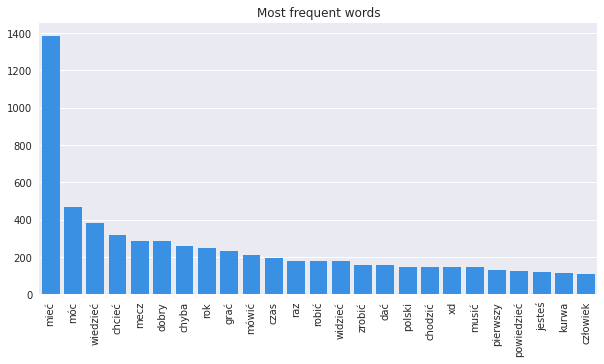

In [134]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences[:25].index, y=sorted_word_occurrences[:25].values, color='dodgerblue')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

- #### Most frequent words in non harmful tweets

In [135]:
word_occurrences_nh = df_cv_2[df['label'] == Labels.NON_HARMFUL.value].sum(axis=0)
sorted_word_occurrences_nh = word_occurrences_nh.sort_values(ascending=False)
sorted_word_occurrences_nh.head(20)

mieć        1299
móc          429
wiedzieć     342
chcieć       307
mecz         285
dobry        279
chyba        242
rok          239
grać         229
mówić        192
czas         182
raz          174
robić        166
widzieć      160
xd           144
chodzić      144
dać          144
zrobić       142
musić        137
polski       125
dtype: int64

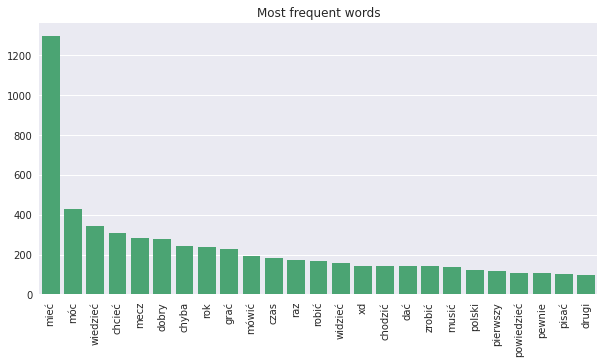

In [136]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences_nh[:25].index, y=sorted_word_occurrences_nh[:25].values, color='mediumseagreen')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

- #### Most frequent words in harmful tweets

In [137]:
word_occurrences_h = df_cv_2[df['label'] == Labels.HARMFUL.value].sum(axis=0)
sorted_word_occurrences_h = word_occurrences_h.sort_values(ascending=False)
sorted_word_occurrences_h.head(20)

mieć          87
jesteś        49
móc           41
wiedzieć      39
kurwa         29
debil         27
dupa          24
polski        23
pisowski      22
pajac         20
mózg          19
chuj          18
mówić         18
powiedzieć    18
widzieć       18
człowiek      17
pis           17
kobieta       16
stary         16
zrobić        15
dtype: int64

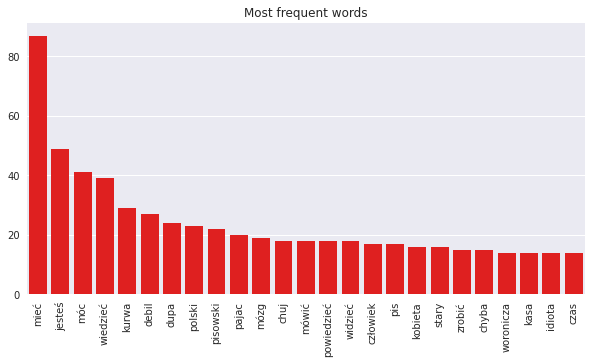

In [138]:
plt.figure(figsize=(10, 5))
g = sns.barplot(x=sorted_word_occurrences_h[:25].index, y=sorted_word_occurrences_h[:25].values, color='red')
g.set_title('Most frequent words')
plt.xticks(rotation=90)
plt.show()

As we can see, the words used differ significantly.
The harmful tweets contain much more curses.

### WordCloud with most frequent words

In [139]:
from wordcloud import WordCloud

In [175]:
def display_frequent_wordcloud(text):
    plt.figure(figsize=(20,20))
    wc = WordCloud(max_words = 100 , width=1600 , height=800, background_color='white').generate(text)
    plt.axis("off")
    plt.imshow(wc)

In [176]:
def text_from_column(df_column):
    return ' '.join(df_column)

- #### Non harmful

In [179]:
non_harmful_tweets = df_clean[df_clean['label'] == Labels.NON_HARMFUL.value]
non_harmful_tweets.head()

,text,label
0,faworyt tytuł cracovia zobaczyć typ sprawdzić,0
1,brawo daria kibic mieć dobry zły,0
2,super polski premiera składać kwiat grób kolab...,0
3,musić droga mieć,0
4,odrzut natychmiastowy kwaśna mina mieć problem,0


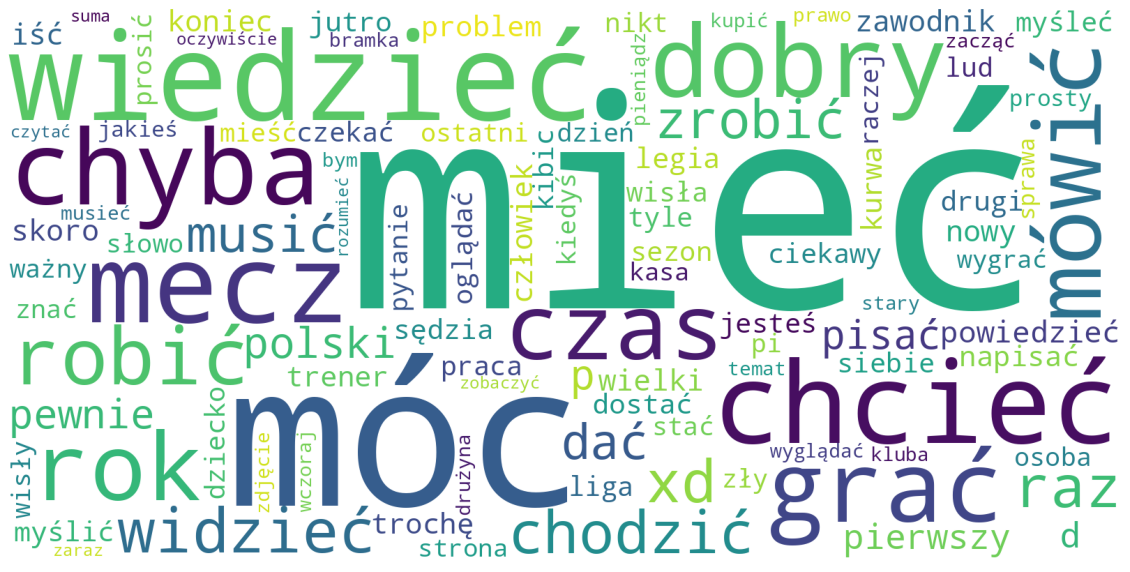

In [180]:
display_frequent_wordcloud(text_from_column(non_harmful_tweets['text']))

- #### Harmful

In [181]:
harmful_tweets = df_clean[df_clean['label'] == Labels.HARMFUL.value]
harmful_tweets.head()

,text,label
9,brudziński jesteś kłamca marny kutas,1
21,skończyć kurwa wersal szczujni,1
39,woronicza poseł halicki oburzony bolkanaprawdè...,1
44,naraz mieć przywidzenie zmieniać fakt czas jes...,1
53,nikt rozsiewać takiego smród,1


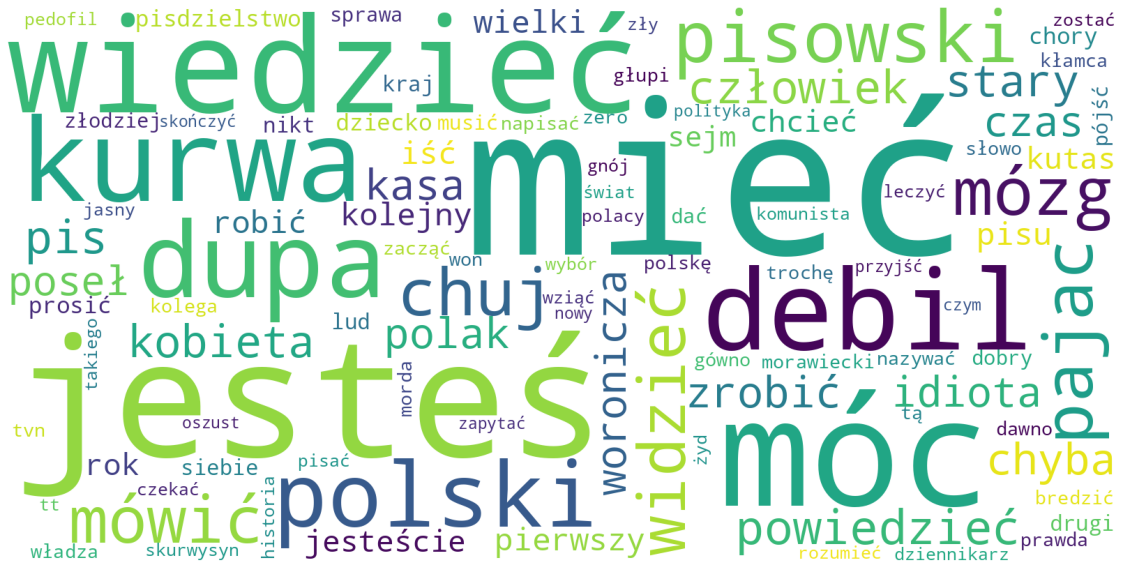

In [182]:
display_frequent_wordcloud(text_from_column(harmful_tweets['text']))

#### Examining the most frequent word (`@anonymized_account`)

The `@anonymized_account` text is the most frequent word in the dataset.
Let's check in how many tweets it is present

In [ ]:
df_lower = df.copy()
df_lower['text'] = df['text'].str.lower()
df_lower.head()

,text,label
0,dla mnie faworytem do tytułu będzie cracovia. ...,0
1,@anonymized_account @anonymized_account brawo ...,0
2,"@anonymized_account @anonymized_account super,...",0
3,@anonymized_account @anonymized_account musi. ...,0
4,"odrzut natychmiastowy, kwaśna mina, mam problem",0


In [ ]:
start_anon_acc_pattern = r'^@anonymized_account'
anon_acc_pattern = r'@anonymized_account'

In [ ]:
df_lower['text'].str.count(anon_acc_pattern).sum()

13762

In [183]:
round(df_lower['text'].str.count(anon_acc_pattern).sum() / num_words)

NameError: name 'df_lower' is not defined

This shows us, that 60% of all words are `@anonymized_account` - tagged accounts

In [ ]:
df_lower['text'].str.match(start_anon_acc_pattern).sum()

7565

Adding a Reply (`Reply`) boolean column

In [184]:
# if startswith.(@anonymized_account) ...

In [185]:
def check_if_reply(tweet_text):
    pass

Mention - if the @anonymized_account is in the middle, or is not followed by another from the start?

In [ ]:
def check_if_mention(tweet_text):
    pass

Adding a RT (Re-Tweets) column?

According to Twitter FAQ, this is not an official feature and cannot be trusted

```
Sometimes people type "RT" at the beginning of a Tweet to indicate that they are re-posting someone else's content. This isn't an official Twitter command or feature, but signifies that they are quoting another person's Tweet.
```

### Most common hash tags #

In [ ]:
# https://towardsdatascience.com/visualization-of-information-from-raw-twitter-data-part-1-99181ad19c

Analysis:
- https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17
- https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28
- https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

- Perform simple analysis:
    - [DONE] Word count by class
    - [DONE] Length of tweets
    - [DONE] Average tweet length by class
    - [IN PROGRESS] Most frequent words
    - Most frequent words by class
- Remove emoji's? Or maybe tokenize them
    - https://github.com/huggingface/transformers/issues/7648
    - https://stackoverflow.com/questions/57679668/tokenizing-emojis-contiguous-to-words

- Check if replying and mentioning other account by `@anonymized_account`, is correlated with the labels
